# Question 1

In [1]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

I.	Fournir une analyse descriptive de l’indice et de ses composantes

a. Calculer les rendements quotidiens en prenant le prix de base ajusté pour les dividendes 

In [2]:
# Source de la question 1 : 
# https://www.pythonforfinance.net/2019/07/02/investment-portfolio-optimisation-with-python-revisited/

# Importation des titres de bourse
tickers = ['AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'XOM',
         'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM',
         'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
         'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)

df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

#Moyenne et variance portefeuille
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

II.	Trouver le portefeuille à variance minimale
a.	Somme des poids = 1
b.	Poids ≥ 0

In [3]:
#Calcul du Sharpe ratio, rendement annuel et écart-type d'un portefeuille
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252     #Rendement par année
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

#Création d'un portefeuille random et calcul de leur propriété
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [4]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(mean_returns, cov, bou):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = bou
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [5]:
min_port_variance = min_variance(mean_returns, cov, (0.0,1.0))
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers)

,0
AXP,0.00
AAPL,0.02
BA,0.00
CAT,0.00
CSCO,0.00
CVX,0.00
DD,0.00
XOM,0.00
GE,0.00
GS,0.00


III.Trouver le portefeuille à variance minimale avec les contraintes additionnelles
a.	Poids minimum = .02 ou 2 %
b.	Poids maximum = .20 ou 20 %

In [6]:
min_port_variance = min_variance(mean_returns, cov, (0.02,0.2))
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers)

,0
AXP,0.02
AAPL,0.02
BA,0.02
CAT,0.02
CSCO,0.02
CVX,0.02
DD,0.02
XOM,0.02
GE,0.02
GS,0.02


IV.	Tracer la frontière efficiente
a.	10 portefeuilles
i.	Rendement min. = Portefeuille à variance minimal
ii.	Rendement max. = 90 % du rendement

In [7]:
num_portfolios = 1000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

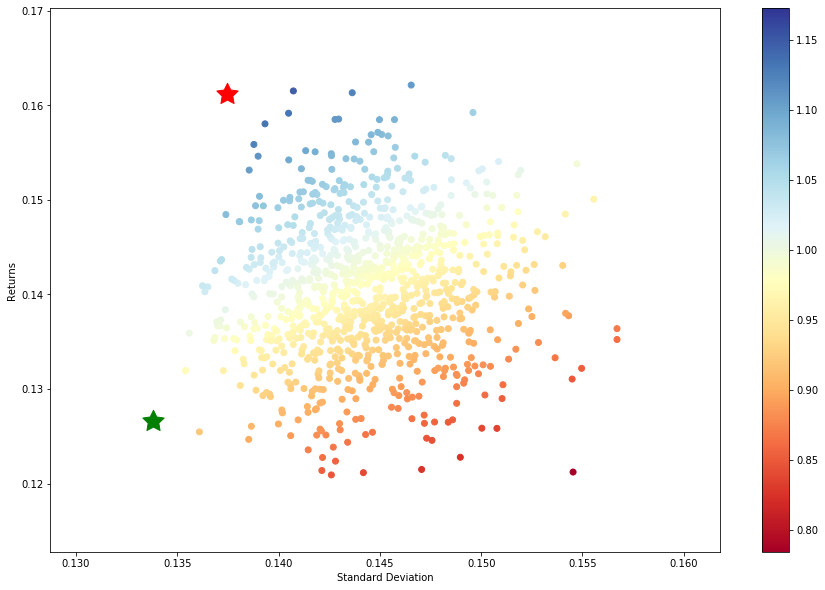

In [8]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()